## Forecast skill WIP

In [1]:
import polars as pl

Let's grab some data and make some simple forecasts. Just to start thinking about the workflow and how to format data.

In [2]:
df = pl.read_csv("../tests/testdata/Vistula/sim1/6158100.csv", try_parse_dates=True, columns=["Date", "Qobs"])

In [3]:
from datetime import timedelta

data = []

# inefficient way, but pre-mature optimization is the root of all evil
for row in df.rows(named=True):
    for i in range(1, 8):
        data.append(
            {
                "time_of_forecast": row["Date"],
                "valid_time": row["Date"] + timedelta(days=i),
                "persistence": row["Qobs"],
            }
        )

In [4]:
fcast_df = (
    pl.DataFrame(data)
    .join(df, left_on="valid_time", right_on="Date")
    .with_columns(pl.col("Qobs").mean().alias("climatology"),
                  (pl.col("valid_time") - pl.col("time_of_forecast")).dt.total_hours().alias("lead_time"))
    .select(["lead_time",pl.col("time_of_forecast").dt.date(), pl.col("valid_time").dt.date(), "persistence", "climatology", pl.col("Qobs").alias("observed")])
)
fcast_df.sample(5)

lead_time,time_of_forecast,valid_time,persistence,climatology,observed
i64,date,date,f64,f64,f64
144,2007-06-30,2007-07-06,8.206,16.077526,14.7
168,2003-12-26,2004-01-02,3.228,16.077526,3.4
48,2009-10-25,2009-10-27,33.07,16.077526,25.86
144,2006-07-08,2006-07-14,18.7,16.077526,13.68
24,2001-04-01,2001-04-02,11.83,16.077526,10.8


In [5]:
import modelskill as ms

cmp = ms.from_matched(fcast_df.to_pandas().set_index("valid_time"), obs_item="observed", mod_items=["persistence", "climatology"], aux_items=["time_of_forecast","lead_time"])

/home/jan/src/modelskill/.venv/lib/python3.12/site-packages/pandas/core/generic.py:3328: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  return xarray.Dataset.from_dataframe(self)
/home/jan/src/modelskill/.venv/lib/python3.12/site-packages/pandas/core/generic.py:3328: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 v

In [6]:
cmp

<Comparer>
Quantity:  []
Observation: observed, n_points=25543
Model(s):
0: persistence
1: climatology
 Auxiliary: time_of_forecast
 Auxiliary: lead_time

In [7]:
cmp.skill(by="lead_time")

,observation,n,bias,rmse,urmse,mae,cc,si,r2
lead_time,,,,,,,,,
24,observed,7304,0.003085,13.038795,13.038795,6.204844,0.635496,0.811446,0.398721
48,observed,7302,0.000276,14.926719,14.926719,7.224847,0.503567,0.928766,0.212119
72,observed,7300,-0.002651,16.218168,16.218168,7.906793,0.403128,1.008935,0.070036
96,observed,7298,-0.005966,17.063058,17.063057,8.346980,0.332978,1.061299,-0.029218
120,observed,7296,-0.009780,17.637476,17.637473,8.652966,0.283305,1.096823,-0.099505
144,observed,7294,-0.014550,17.966940,17.966934,8.851793,0.254114,1.117104,-0.140784
168,observed,7292,-0.018521,18.126364,18.126354,9.032625,0.239885,1.126807,-0.160933


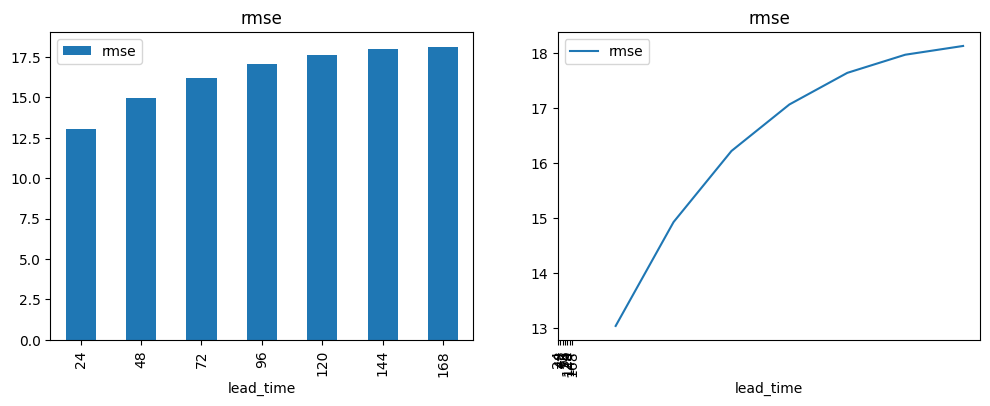

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

cmp.skill(by="lead_time").rmse.plot.bar(ax=ax[0]);
cmp.skill(by="lead_time").rmse.plot.line(ax=ax[1]);